# General Experiment.
Modular setup of the AL experiments

## libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import laplace
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from batchbald_redux import repeated_mnist, active_learning, batchbald
from main.models import BayesianConvNet, ConvNet
from main.utils import save_experiment, load_experiment
from laplace.curvature import BackPackGGN, CurvlinopsGGN, AsdfghjklEF
from main.laplace_batch import get_laplace_batch


%reload_ext autoreload
%autoreload 2

c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data and experiment parameters

In [7]:
# loading data
train_dataset, test_dataset = repeated_mnist.create_MNIST_dataset()

# number of initial samples 
num_initial_samples = 40
num_classes = 10

# get indices of initial samples
initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)

# Experiment parameters

## Active learning parameters
max_training_samples = 100  # Maximum number of samples to acquire from the pool dataset 
acquisition_batch_size = 5  # Number of samples to acquire in each acquisition step

## Training parameters
test_batch_size = 512  # Batch size for testing
batch_size = 64  # Batch size for training
scoring_batch_size = 64  # Batch size for scoring 
training_iterations_nn = 4096 * 6  # Number of training iterations (batches) to run
training_iterations_la = 2**10  # Number of training iterations (batches) to run

## Model parameters
hessian_structure = "kron"  # Options: "full", "kron", "lowrank" and "diag"
subset_of_weights = "last_layer"  # Options: "all", "subnetwork" and "last_layer"
backend = AsdfghjklEF  # Options: CurvlinopsGGN, CurvlinopsEF, AsdfgjklEF, AsdfghjklGGN, BackPackGGN
al_method = 'probit_entropy'  # logit_entropy or probit_entropy

kwargs = {"num_workers": 1, "pin_memory": True}

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

print(f"use_cuda: {use_cuda}")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(55000)

train_loader_nn = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations_nn),
    batch_size=batch_size,
    **kwargs,
)

train_loader_la = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations_nn),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

use_cuda: False


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\torch\utils\data\sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


## Running Experiment

In [3]:
# Run experiment
test_accs = []
test_loss = []
added_indices = []
added_labels = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")
loss_fn = nn.NLLLoss()

while True:
    model = ConvNet().to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader_nn, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = F.log_softmax(model(data).squeeze(1), dim=1)
        loss = loss_fn(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = model(data).squeeze(1)
            loss += loss_fn(prediction, target)

            prediction = prediction.argmax(dim=1)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire new batch from pool samples using entropy acquisition function
    N = len(active_learning_data.pool_dataset)
    
    la = laplace.Laplace(
                        model,
                        likelihood="classification",
                        subset_of_weights=subset_of_weights,
                        hessian_structure=hessian_structure,
                        backend=backend
                     )
    
    print('Fitting Laplace')
    la.fit(train_loader_la, progress_bar=True)

    print('Optimizing prior precision')
    la.optimize_prior_precision(method='marglik', verbose=True)

    candidate_batch = get_laplace_batch(model=la, pool_loader=pool_loader,
                                            acquisition_batch_size=acquisition_batch_size,
                                            device=device, 
                                            method=al_method)


    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    added_labels.append(targets[candidate_batch.indices])
    pbar.update(len(dataset_indices))

Training Set Size:  40%|████      | 40/100 [00:00<?, ?it/s]

Test set: Average loss: -0.0278, Accuracy: 7457/10000 (74.57%)
Fitting Laplace


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\laplace\baselaplace.py:409: UserWarning: By default `link_approx` is `probit`. Make sure to set it equals to the way you want to call `la(test_data, pred_type=..., link_approx=...)`.
  warnings.warn(


Optimizing prior precision
Optimized prior precision is tensor([7.5089]).


Training Set Size:  45%|████▌     | 45/100 [01:02<11:31, 12.56s/it]

Dataset indices:  [30286  4946  8698 39294  7705]
Scores:  [1.7988738970631246e-11, 1.7331892865346532e-11, 1.6345652262272914e-11, 1.617200817705111e-11, 1.589125879497555e-11]
Labels:  tensor([7, 7, 7, 7, 4])


Test set: Average loss: -0.0190, Accuracy: 7608/10000 (76.08%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([6.6251]).


Training Set Size:  50%|█████     | 50/100 [02:03<10:18, 12.37s/it]

Dataset indices:  [33698    29 49531 40561 24557]
Scores:  [9.930556377213406e-12, 9.689525223843809e-12, 9.553628721459262e-12, 8.961112234195934e-12, 7.444510286003236e-12]
Labels:  tensor([2, 7, 7, 1, 2])


Test set: Average loss: -0.0118, Accuracy: 7893/10000 (78.93%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([9.3792]).


Training Set Size:  55%|█████▌    | 55/100 [03:11<09:40, 12.89s/it]

Dataset indices:  [10460 18327 46778  8890 29788]
Scores:  [3.489885897628442e-12, 3.2323397430866763e-12, 3.1359530857505424e-12, 2.9066571198554936e-12, 2.8922079575027793e-12]
Labels:  tensor([4, 4, 9, 4, 4])


Test set: Average loss: -0.0191, Accuracy: 7682/10000 (76.82%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([8.6243]).


Training Set Size:  60%|██████    | 60/100 [04:20<08:48, 13.21s/it]

Dataset indices:  [ 3432 35750 38510 56717 39441]
Scores:  [4.951821938603551e-12, 4.6438551788707816e-12, 4.016518454635909e-12, 3.987367293983857e-12, 3.830556531692064e-12]
Labels:  tensor([8, 6, 8, 1, 1])


Test set: Average loss: -0.0192, Accuracy: 7725/10000 (77.25%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([11.1427]).


Training Set Size:  65%|██████▌   | 65/100 [05:25<07:40, 13.17s/it]

Dataset indices:  [34866 47021   552 34402 49482]
Scores:  [1.8628403940929017e-12, 1.0606046206215747e-12, 8.904085151487107e-13, 8.615184845899015e-13, 8.613414885852433e-13]
Labels:  tensor([3, 5, 1, 1, 1])


Test set: Average loss: -0.0217, Accuracy: 7711/10000 (77.11%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([12.9672]).


Training Set Size:  70%|███████   | 70/100 [06:30<06:34, 13.14s/it]

Dataset indices:  [57040 20352 20930 14751  3154]
Scores:  [4.987916546808635e-13, 4.0096146346722816e-13, 3.938264373903183e-13, 2.6128865781085975e-13, 2.3994117782054347e-13]
Labels:  tensor([3, 8, 2, 8, 8])


Test set: Average loss: -0.0235, Accuracy: 8158/10000 (81.58%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([13.8862]).


Training Set Size:  75%|███████▌  | 75/100 [07:37<05:29, 13.19s/it]

Dataset indices:  [28341 17741  1512 36429 56590]
Scores:  [5.739016168760172e-14, 4.61602937405943e-14, 3.8424511239910225e-14, 3.6182299832047266e-14, 3.4980078864954925e-14]
Labels:  tensor([8, 0, 0, 8, 2])


Test set: Average loss: -0.0232, Accuracy: 8170/10000 (81.70%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([12.0130]).


Training Set Size:  80%|████████  | 80/100 [08:45<04:26, 13.33s/it]

Dataset indices:  [20363 20771 22604 48475 50981]
Scores:  [2.4905500838751093e-13, 1.6315964692596024e-13, 9.226857288196361e-14, 7.98774024354798e-14, 7.95632955135836e-14]
Labels:  tensor([8, 8, 8, 8, 4])


Test set: Average loss: -0.0226, Accuracy: 8213/10000 (82.13%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([15.5738]).


Training Set Size:  85%|████████▌ | 85/100 [09:54<03:22, 13.49s/it]

Dataset indices:  [14881 20165 21134 29786 13054]
Scores:  [2.924591314566391e-14, 3.76069160757048e-15, 3.233328471093479e-15, 2.4065171649054543e-15, 2.0973060934443774e-15]
Labels:  tensor([2, 2, 4, 7, 0])


Test set: Average loss: -0.0301, Accuracy: 8230/10000 (82.30%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([13.2488]).


Training Set Size:  90%|█████████ | 90/100 [11:02<02:14, 13.50s/it]

Dataset indices:  [45576 58456 11784 24849 42121]
Scores:  [5.531938974826303e-14, 5.2953023639123326e-14, 4.75547505291319e-14, 3.7393421421349354e-14, 3.446311771658668e-14]
Labels:  tensor([8, 5, 6, 2, 5])


Test set: Average loss: -0.0312, Accuracy: 8205/10000 (82.05%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([15.3086]).


Training Set Size:  95%|█████████▌| 95/100 [12:10<01:07, 13.55s/it]

Dataset indices:  [26548 53182  7150 41495 12044]
Scores:  [1.3175346772788255e-13, 7.942612360997345e-14, 5.855486587139427e-14, 2.7841906907678966e-14, 2.7552777293331394e-14]
Labels:  tensor([3, 3, 3, 8, 3])


Test set: Average loss: -0.0227, Accuracy: 8353/10000 (83.53%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([15.2634]).


Training Set Size: 100%|██████████| 100/100 [13:20<00:00, 13.65s/it]

Dataset indices:  [24751  7621 26575   576 28632]
Scores:  [6.058981255222884e-15, 3.661626869224353e-15, 3.562922543397283e-15, 2.864180289493504e-15, 2.5403500646375282e-15]
Labels:  tensor([2, 7, 7, 4, 7])


Test set: Average loss: -0.0345, Accuracy: 8399/10000 (83.99%)


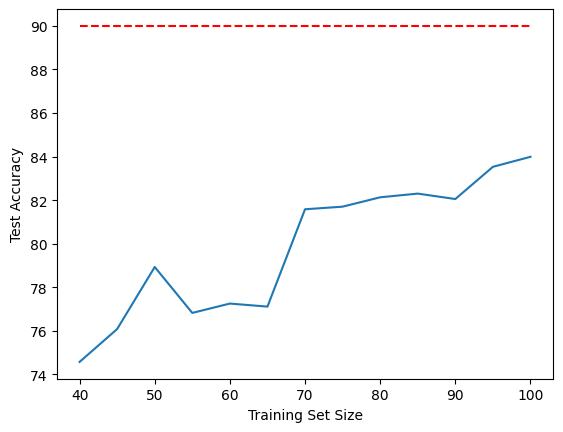

In [4]:
plt.plot(np.arange(start=num_initial_samples, stop=max_training_samples + acquisition_batch_size, step=acquisition_batch_size), test_accs)
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.hlines(90, num_initial_samples, max_training_samples, colors='r', linestyles='dashed')

plt.show()

## Storing results

In [5]:
params_dict = {
    'num_initial_samples': num_initial_samples,
    'num_classes': num_classes,
    'max_training_samples': max_training_samples,
    'acquisition_batch_size': acquisition_batch_size,
    'test_batch_size': test_batch_size,
    'batch_size': batch_size,
    'scoring_batch_size': scoring_batch_size,
    'training_iterations_nn': training_iterations_nn,
    'training_iterations_la': training_iterations_la,
}

# generate a unique experiment id of 3 digits (just to make sure don't override things, clean up later)
experiment_id = np.random.randint(1000, 9999)
save_experiment(f'{al_method}_{hessian_structure}_{subset_of_weights}_K{acquisition_batch_size}_{experiment_id}',
                params_dict, {
    'test_accs': test_accs,
    'test_loss': test_loss,
    'added_indices': added_indices
})